In [67]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [80]:
N = 1000
p = 300
T = 120
idiovol_sigma = np.sqrt(0.3*0.3/12)
e_mu = np.sqrt(0.2*0.2/12)
e_sigma = e_mu
mu = 0.1/12/e_mu
sigma_beta = 1
a = 1.5
b = 1.5
w0 = np.zeros(N) # for now
returns = []

# values_new = []
# gamma = [0.5,1,1.5,2,2.5,5,7.5,10]
gamma = 0.5
# gamma = 1
c = 0.01
values_new = []

value_gamma = []
# lambdas_commons = []
# for gammas in gamma:
    for s in range(100): # can change the simulation number
        t = np.random.normal(e_mu,e_sigma,N) # generate the eij for each factor
        betas = np.zeros((N,p)) # the decaying path of each factor beta
        beta_bar = np.zeros((1,p))
        betas[:,0] = t
        beta_bar[:,0] = e_mu
        mus = np.zeros((1,p))
        mus[:,0] = mu
        for j in range(1,p):
            betas[:,j-1] = t*j**(-a)
            beta_bar[:,j-1] = np.mean(betas[:,j-1])# the average beta for calculating lambda
            mus[:,j-1] = mu*j**(-b)
        alpha = (betas * mus).sum(axis = 1) # the factor risk premia
        alpha_bar = (beta_bar * mus).sum(axis = 1) # the average alpha for calculating lambda
        beta_hat_stocks = [] # to store the betas for each stock after their ridge regression
        alpha_hat_stocks = [] # to store the alphas for each stock after their ridge regression
        sigma_ridge = []
        returns = []
        lambda_common = idiovol_sigma**2 * (p+1)/((alpha_bar**2 + (beta_bar**2).sum())*T)
        lambdas_commons.append(lambda_common)
        for stock in range(N):
            f = np.random.multivariate_normal(np.zeros(p), np.identity(p), T) # for each stock generate the factor matrix
            epsilon = np.random.normal(0,idiovol_sigma,T) #generate the residuals
            r = alpha[stock] + np.array(betas[stock]).T @ f.T + epsilon # calculate the return series for each stock
            returns.append(r)
#             lamb = idiovol_sigma**2 * (p+1)/((alpha[stock]**2 + sum(betas[stock]**2))*T)
            ridge = Ridge(alpha = lambda_common,fit_intercept = True)
            ridge.fit(f, r)
            beta_hat_stocks.append(ridge.coef_)
            alpha_hat_stocks.append(ridge.intercept_)
            sigma_ridge.append(np.var(r - ridge.intercept_ - ridge.coef_ @ f.T))

        sigma_hat = np.array(beta_hat_stocks) @ np.array(beta_hat_stocks).T + sigma_ridge @ np.identity(N)
        weights = np.linalg.inv(gammas * sigma_hat + c * np.identity(N)) @ (alpha_hat_stocks + c * w0)
        sigma_true = betas @ betas.T + np.identity(N)*idiovol_sigma**2 
        value = weights.T @ alpha - 0.5*gammas*weights.T @ sigma_true @ weights - 0.5*c*np.sqrt(sum((weights - w0)**2))
        values_new.append(value)

#     value_gamma.append(np.mean(values_new))

In [81]:
value_gamma

[-5.814597496779083,
 -7.009271964130653,
 -8.073548673752333,
 -9.296071821637147,
 -10.412895284390755,
 -13.226387113976658,
 -17.17478837608071,
 -21.545478310971074]

Text(0.5, 0, 'Gamma')

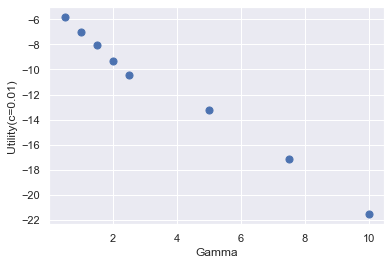

In [82]:
plt.scatter(y = value_gamma, x = gamma, s = 50)
plt.ylabel('Utility(c=0.01)')
plt.xlabel('Gamma')

In [35]:
lambdas_commons

[array([4.61965125]),
 array([4.93760497]),
 array([4.68414261]),
 array([4.69356491]),
 array([4.74203476])]